**Introduction**

The Linking writting process to quality contest aims to use the keyboard input logs to predict a student's writting score，the train data contains several essay's log info,We are given a date like that:

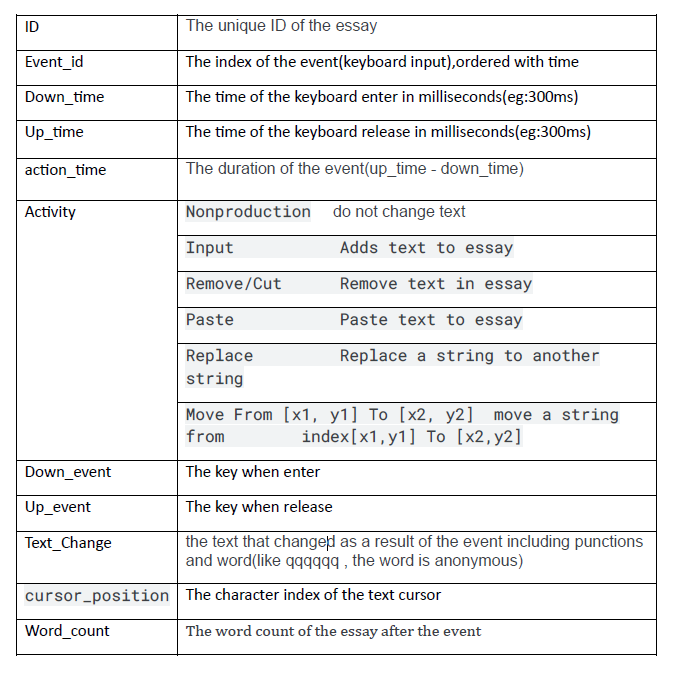

What we need to do is to predict the score of each essay.
* id,score
* 0000aaaa,1.0
* 2222bbbb,2.0
* 4444cccc,3.0

Evaluation use RMSE 


The log data are clean and have no missing value.and we think this keyboard input data logs is very important.Here is the plan:

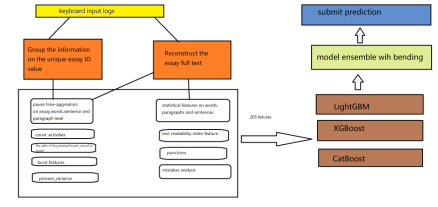

### Import necessary libraries.

In [1]:
import pandas as pd#导入csv文件的库
import numpy as np#进行矩阵运算的库
import polars as pl#和pandas类似,但是处理大型数据集有更好的性能.
#用于对一组元素计数,一个存在默认值的字典,访问不存在的值时抛出的是默认值
from collections import Counter,defaultdict
import re#用于正则表达式提取
from scipy.stats import skew, kurtosis#统计分析和概率分布导入偏度和峰度

#model
from lightgbm import LGBMRegressor#导入lgbm回归器
from catboost import CatBoostRegressor#catboost回归器
from xgboost import XGBRegressor#导入XGB回归器

#KFold是直接分成k折,StratifiedKFold还要考虑每种类别的占比
from sklearn.model_selection import StratifiedKFold

#设置随机种子,保证模型可以复现
import random
seed=2024
np.random.seed(seed)
random.seed(seed)

import warnings#避免一些可以忽略的报错
warnings.filterwarnings('ignore')#filterwarnings()方法是用于设置警告过滤器的方法，它可以控制警告信息的输出方式和级别。

### The function used to obtain the content of the essays.

In [2]:
def get_Essays(df):
    #传入的是其中一个id的论文,取出id
    USER_ID = df["id"].iloc[0]
    #这个id和论文内容相关的几列
    textInputDf = df[['activity', 'cursor_position', 'text_change']]
    #对论文没有变化的动作不用管
    currTextInput = textInputDf[textInputDf.activity != 'Nonproduction']
    essayText = ""#开始重构论文内容.
    for Input in currTextInput.values:#取出一个'activity', 'cursor_position', 'text_change'
        #input[0]是这个id的activity
        if Input[0] == 'Replace':
            #text_change按照' => '分开 replaceTxt:[' qqq qqqqq ', ' ']
            replaceTxt = Input[2].split(' => ')#应该是A=>B的操作
            #input[1]是鼠标位置,是一个数字 鼠标位置-len()
            #这是一个字符串的转换操作,由replaceTxt[0]转成replaceTxt[1] 
            essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] +essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
            continue
        if Input[0] == 'Paste':#在Input[1]的位置粘贴Input[2]
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
            continue
        if Input[0] == 'Remove/Cut':#删除剪切 在Input[1]的位置删除Input[2]
            essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
            continue
        #如果是Move from
        if "M" in Input[0]:
            #[284, 292] To [282, 290] 把[284, 292]这8行移动到[282,290]
            croppedTxt = Input[0][10:]
            #from和to的4个数字分开.
            splitTxt = croppedTxt.split(' To ')
            valueArr = [item.split(', ') for item in splitTxt]
            moveData = (int(valueArr[0][0][1:]), 
                        int(valueArr[0][1][:-1]), 
                        int(valueArr[1][0][1:]), 
                        int(valueArr[1][1][:-1]))
            #位置不相等,如果位置相等,等于什么都没有做
            if moveData[0] != moveData[2]:
                #行号小于 
                if moveData[0] < moveData[2]:
                    essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] +\
                    essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                #行号大于
                else:
                    essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] +\
                    essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
            continue
        #由于continue会跳过这个循环,这里应该是在Input[1]的位置'Input'了Input[2]
        essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]     
            
    return USER_ID, essayText

### A function used to obtain features of words, sentences, and paragraphs in the essays.

In [3]:
AGGREGATIONS = ['count','min','max','first','last', 'median','sum','std']

#将论文转成单词
def word_feats(df):
    essay_df = df
    #对空格,\n,句号问号感叹号,逗号进行匹配,得到一个拆分后的列表.
    essay_df['word'] = essay_df['essay'].apply(lambda x: re.split(' |\\n|\\.|\\?|\\!|\\,',x))
    # essay1 [1,2,3] essay2[4,5] ->5行 essay1 1  // essay1 2 // essay1 3 // essay2 1 // essay2 2
    essay_df = essay_df.explode('word')
    #求出每个单词的长度
    essay_df['word_len'] = essay_df['word'].apply(lambda x: len(x))
    #去掉单词长度为0的数据,应该是标点符号和换行符之间,换行符与空格之间之类的.
    word_df = essay_df[essay_df['word_len'] != 0]
   
    #根据id计算单词长度的统计学变量
    word_agg_df = word_df[['id','word_len']].groupby(['id']).agg(AGGREGATIONS)
    #比如('mean','word_len')->'mean_word_len'
    word_agg_df.columns = ['_'.join(x) for x in word_agg_df.columns]
    word_agg_df['id'] = word_agg_df.index
#     for word_l in [5, 6, 7, 8, 9, 10, 11, 12]:
#         #ge 就是Latex里>=的符号,筛选出word_len>=word_l的行,根据id进行统计,提取每个计数的第0行
#         word_agg_df[f'word_len_ge_{word_l}_count'] = word_df[word_df['word_len'] >= word_l].groupby(['id']).count().iloc[:, 0]
#         #如果有缺失值就填充为0
#         word_agg_df[f'word_len_ge_{word_l}_count'] = word_agg_df[f'word_len_ge_{word_l}_count'].fillna(0)
    #重置索引
    word_agg_df = word_agg_df.reset_index(drop=True)
    return word_agg_df

#句子特征
def sent_feats(df):
    essay_df = df#传入的df就是论文的df
    #对句子按照. ? !进行拆分. 得到一个拆分后的列表.
    essay_df['sent'] = essay_df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',x))
    # essay1 [1,2,3] essay2[4,5] ->5行 essay1 1  // essay1 2 // essay1 3 // essay2 1 // essay2 2
    essay_df = essay_df.explode('sent')
    #将换行符'\n'变成空白字符 strip 去除行头和行尾的空白字符.
    essay_df['sent'] = essay_df['sent'].apply(lambda x: x.replace('\n','').strip())
    #统计一下每个句子的长度 
    essay_df['sent_len'] = essay_df['sent'].apply(lambda x: len(x))
    #求一下每个句子单词的个数.
    essay_df['sent_word_count'] = essay_df['sent'].apply(lambda x: len(x.split(' ')))
    #去掉那些句子长度为0的数据
    df = essay_df[essay_df.sent_len!=0].reset_index(drop=True)
    
    #统计句子长度的统计学变量和每个句子词数的统计学变量
    sent_agg_df = pd.concat(
        [df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    )
    #比如('mean','sent_len')->'mean_sent_len'
    sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
    sent_agg_df['id'] = sent_agg_df.index
    
#     # New features intoduced here: https://www.kaggle.com/code/mcpenguin/writing-processes-to-quality-baseline-v2
#     for sent_l in [50, 60, 75, 100]:
#         #ge 就是Latex里>=的符号,筛选出sent_len>=sent_l的行,根据id进行统计,提取每个计数的第0行
#         sent_agg_df[f'sent_len_ge_{sent_l}_count'] = df[df['sent_len'] >= sent_l].groupby(['id']).count().iloc[:, 0]
#         #如果有缺失值就填充为0
#         sent_agg_df[f'sent_len_ge_{sent_l}_count'] = sent_agg_df[f'sent_len_ge_{sent_l}_count'].fillna(0)
    #重置索引
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    #一句话里词的个数的count,其实就是有多少句话,也就是sent_len的count.重复了,故去掉.
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    #sent_len_count其实就是有多少句话,故rename.
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
    return sent_agg_df

def parag_feats(df):
    essay_df = df
    #按照'\n'划分成段落 [1,2,3]
    essay_df['paragraph'] = essay_df['essay'].apply(lambda x: x.split('\n'))
    #[论文1 [段落1 段落2,……]->[论文1 段落1 // 论文1 段落2]
    essay_df = essay_df.explode('paragraph')
    #统计段落的长度
    essay_df['paragraph_len'] = essay_df['paragraph'].apply(lambda x: len(x)) 
    #统计每个段落的词数
    essay_df['paragraph_word_count'] = essay_df['paragraph'].apply(lambda x: len(x.split(' ')))
    essay_df['paragraph_sent_count'] = essay_df['paragraph'].apply(lambda x: len(re.split('\\.|\\?|\\!',x)))
    #将段落长度>2的文本留下来.
    df = essay_df[essay_df.paragraph_len>2].reset_index(drop=True)

    paragraph_agg_df = pd.concat(
        [df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS), 
         df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS),
         df[['id','paragraph_sent_count']].groupby(['id']).agg(AGGREGATIONS)
        ], axis=1
    ) 
    paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df['id'] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    #段落词数的数量就是段落的数量,也就是paragraph_len_count,段落句子数的数量同理,故drop
    paragraph_agg_df.drop(columns=["paragraph_word_count_count", "paragraph_sent_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
    return paragraph_agg_df

### Text Readability Index

If two essays contains same amount of characters,the less the sentences it contain,the more characters each sentence will contain,which means it is very hard to understand long length senteces.

In [4]:
#文本的自动可读性指数 旨在衡量文本的可理解性.输出是理解课文所需的美国年级水平的近似表示.
#https://www.nhooo.com/note/qa0tpe.html
#初步理解:相同词数的情况下,句子越少,说明句子相对来说会很长,越长越不容易理解.words/sentence就会越大.
#字符数相同的情况下,词数越多,单词越短,短的单词可能简单,所以就好理解.characters/words变小.
#数值小就好理解,数值大就不好理解.具体的公式可能用数据做过实验得出?
def ARI(txt):
    characters=len(txt)
    words=len(re.split(' |\\n|\\.|\\?|\\!|\,',txt))#空格,换行符,句号,问号,感叹号,逗号分开.
    sentence=len(re.split('\\.|\\?|\\!',txt))#句号,问号,感叹号分开的句子.
    ari_score=4.71*(characters/words)+0.5*(words/sentence)-21.43
    return ari_score
"""
http://www.supermagnus.com/mac/Word_Counter/index.html
McAlpine EFLAW© Test
     (W + SW) / S
McAlpine EFLAW© Readability
     Scale:
     1-20: Easy
     21-25: Quite Easy
     26-29: Mildly Difficult
     ≥ 30: Very Confusing
     S:total sentences
     W:total words
"""
def McAlpine_EFLAW(txt):
    W=len(re.split(' |\\n|\\.|\\?|\\!|\,',txt))#空格,换行符,句号,问号,感叹号,逗号分开.
    S=len(re.split('\\.|\\?|\\!',txt))#句号,问号,感叹号分开的句子.
    mcalpine_eflaw_score=(W+S*W)/S
    return mcalpine_eflaw_score
"""
https://readable.com/readability/coleman-liau-readability-index/

=0.0588*L-0.296*S-15.8
L是每100个单词有多少个字母,S是平均每100个单词有多少句子.
"""
def CLRI(txt):
    characters=len(txt)
    words=len(re.split(' |\\n|\\.|\\?|\\!|\,',txt))#空格,换行符,句号,问号,感叹号,逗号分开.
    sentence=len(re.split('\\.|\\?|\\!',txt))#句号,问号,感叹号分开的句子.
    L=100*characters/words
    S=100*sentence/words
    clri_score=0.0588*L-0.296*S-15.8
    return clri_score

### Extracting features from the text chunk.

In [5]:
#获取文本块的特征.
def get_text_chunk_features(df):
    punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    #计算论文的长度
    df['text_length'] = df['essay'].apply(len)

    #计算换行符的个数.
    df['num_newlines'] = df['essay'].apply(lambda x: x.count('\n'))
    #文本可读性的3个指标
    df['automated_readability_index'] = df['essay'].apply(ARI)
    df['mcalpine_eflaw'] = df['essay'].apply(McAlpine_EFLAW)        
    df['coleman_liau'] = df['essay'].apply(CLRI)

    #字符‘q’在总字符数中的占比,其他的可能是空格和标点符号
    df['repetitiveness'] = df['essay'].apply(lambda x: x.count('q') / max(len(x), 1))

    #平均词长度=所有的词的总长度/总词数
    df['avg_word_length'] = df['essay'].apply(lambda x: sum(len(word) for word in x.split()) / max(1, len(x.split())))
    #单词紧急多样性 set(x.split())=['qq','qqq','qqqq'……],len(x.split())是论文总词数
    df['word_lexical_diversity'] = df['essay'].apply(lambda x: len(set(x.split())) / len(x.split()))
        
    #单引号和双引号的使用次数.
    df['num_s_quotations'] = df['essay'].apply(lambda x: x.count("'"))
    df['num_d_quotations'] = df['essay'].apply(lambda x: x.count('"'))
    #问号、感叹号,逗号,句号的使用次数
    df['qm_count'] = df['essay'].apply(lambda x: x.count('?'))
    df['excm_count'] = df['essay'].apply(lambda x: x.count('!'))
    df['comma_count'] = df['essay'].apply(lambda x: x.count(','))
    df['dot_count'] = df['essay'].apply(lambda x: x.count('.'))
    #冒号和分号的使用次数
    df['num_prelist_count'] = df['essay'].apply(lambda x: x.count(':')) +\
                            df['essay'].apply(lambda x: x.count(";"))    
    
    #空白字符例如:空格,换行符,制表符后面有一个句号的错误.
    df["space_n_dot_mistake"] = df['essay'].apply(lambda x: len(re.findall(r'\s\.', x)))
    #空白字符例如:空格,换行符,制表符后面有一个逗号的错误.
    df["space_n_comma_mistake"] = df['essay'].apply(lambda x: len(re.findall(r'\s\,', x)))
    #空白字符例如:空格,换行符,制表符前面有一个句号的错误.
    df["comma_n_nonspace_mistake"] = df['essay'].apply(lambda x: len(re.findall(r'\,\S', x)))
    #空白字符例如:空格,换行符,制表符前面有一个逗号的错误.
    df["dot_n_nonspace_mistake"] = df['essay'].apply(lambda x: len(re.findall(r'\.\S', x)))
    #总共有几个错误,对错误做一个汇总.
    df["total_punc_mistake"] = (
        df["space_n_dot_mistake"] +
        df["space_n_comma_mistake"] +
        df["comma_n_nonspace_mistake"] +
        df["dot_n_nonspace_mistake"]
    )
    #标点符号犯错误的次数/4种标点符号的使用次数(问号和感叹号出现次数不多)
    df["punc_mistake_ratio"] = df["total_punc_mistake"] / (df['qm_count'] +
                                                           df['excm_count'] +
                                                           df['comma_count'] +
                                                           df['dot_count'])

    #统计不同的单词种类. 
    df['unique_word_count'] = df['essay'].apply(lambda x: len(set(re.findall(r'\w+', x.lower()))))
    
    #统计每种标点符号出现的次数和
    df['punctuation_count'] = df['essay'].apply(lambda x: sum(x.count(p) for p in punctuation)) 

    return df

### Standardize the essays, and then call the function mentioned above. This is the feature extraction of the essays.

In [6]:
#对一段文本txt进行处理的函数
def standardize_text(txt):
    txt = re.sub(r'\t' , '', txt)#将文本中的制表符替换成空字符串
    txt = re.sub(r'\n {1,}' , '\n', txt)#换行符后面如果有空格,去掉
    txt = re.sub(r' {1,}\n' , '\n', txt)#换行符前面有空格的话去掉
    txt = re.sub(r'\n{2,}' , '\n', txt)#如果有2个以上的换行符,替换成单个换行符
    txt = re.sub(r' {2,}' , ' ', txt)#如果有出现连续2个空格,替换成单个空格.
    txt = txt.strip()#开头和结尾如果有空白字符去掉
    return txt#返回经过处理的文本
def TextProcessor(inp_df):

    for rowi in range(len(inp_df)):
        #如果一篇论文删除空格后什么都没有,替换为'q',好心假装你写了东西.
        if inp_df.loc[rowi, "essay"].replace(" ", "") == "":
            inp_df.loc[rowi, "essay"] = "q"   
    
    #对传入的论文去掉一些多余的字符.
    inp_df["essay"] = inp_df["essay"].apply(lambda x: standardize_text(txt=x))
    
    #获取文本块的相关特征.
    print("creating complete features")
    inp_df = get_text_chunk_features(inp_df) 
    #获取文本的单词,句子,段落特征
    wf_df = word_feats(inp_df)
    sf_df = sent_feats(inp_df)
    pf_df = parag_feats(inp_df)
    #将论文
    inp_df = inp_df.merge(wf_df, how="left", on="id")
    inp_df = inp_df.merge(sf_df, how="left", on="id")
    inp_df = inp_df.merge(pf_df, how="left", on="id")
    #提取好特征,把论文,词语,句子,段落去掉
    inp_df.drop(["essay", "word", "sent", "paragraph"],axis=1,inplace=True)
    
    return inp_df

### The following is feature extraction for logs.

In [7]:
#数值列,activity,event和text_change的重要类别
num_cols = ['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count', 'event_id']
activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
text_changes = ['q', ' ', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']

#df表格的colname列统计values的count.
def count_by_values(df, colname, values):
    #maintain_order=True保持原有顺序
    fts = df.select(pl.col('id').unique(maintain_order=True))
    for i, value in enumerate(values):
        #根据每个id判断colname是不是value并统计个数,rename成colname_i_cnt
        tmp_df = df.group_by('id').agg(pl.col(colname).is_in([value]).sum().alias(f'{colname}_{i}_cnt'))
        #加上这个特征
        fts  = fts.join(tmp_df, on='id', how='left') 
    return fts
#暂停状态的特征聚合
def pause_stat_aggregator(df, prefix="iw"):
    temp = df.group_by("id").agg(
           #根据id计算time_diff的最大,中位数,均值,最小值,方差,sum
           pl.max('time_diff').alias(f"{prefix}_max_pause_time"),
           pl.median('time_diff').alias(f"{prefix}_median_pause_time"),
           pl.mean('time_diff').alias(f"{prefix}_mean_pause_time"),
           pl.min('time_diff').alias(f"{prefix}_min_pause_time"),
           pl.std('time_diff').alias(f"{prefix}_std_pause_time"),
           pl.sum('time_diff').alias(f"{prefix}_total_pause_time"),
           # time_diff在(0.5,1) (1,2) (2,3) >3的count.
           pl.col('time_diff').filter((pl.col('time_diff') > 0.5) & (pl.col('time_diff') <= 1)).count().alias(f"{prefix}_pauses_half_sec"),
           pl.col('time_diff').filter((pl.col('time_diff') > 1) & (pl.col('time_diff') <= 2)).count().alias(f"{prefix}_pauses_1_sec"),
           pl.col('time_diff').filter((pl.col('time_diff') > 2) & (pl.col('time_diff') <= 3)).count().alias(f"{prefix}_pauses_2_sec"),
           pl.col('time_diff').filter(pl.col('time_diff') > 3).count().alias(f"{prefix}_pauses_3_sec")
    )
    return temp  

def dev_feats(df):
    
    print("< Count by values features >")
    
    #统计activity,text_change,down_event,up_event这几个类别型变量的count down_event和up_event基本一样.
    feats = count_by_values(df, 'activity', activities)
    feats = feats.join(count_by_values(df, 'text_change', text_changes), on='id', how='left') 
    feats = feats.join(count_by_values(df, 'down_event', events), on='id', how='left') 

    print("< Numerical columns features >")

    #对action_time求和,对数值型变量求均值,方差,中位数,最小值,最大值,50%的数字 没有pl.mean(num_cols).suffix('_mean')和pl.quantile(num_cols, 0.5).suffix('_quantile')
    temp = df.group_by("id").agg(pl.sum('action_time').suffix('_sum'),pl.std(num_cols).suffix('_std'),
                                 pl.median(num_cols).suffix('_median'), pl.min(num_cols).suffix('_min'),
                                 pl.max(num_cols).suffix('_max'),
                                 )
    feats = feats.join(temp, on='id', how='left') 
    
    print("< Categorical columns features >")
    #类别型变量求了n_unique,加入特征.
    temp  = df.group_by("id").agg(pl.n_unique(['activity', 'down_event', 'up_event', 'text_change']))
    feats = feats.join(temp, on='id', how='left') 
    
    
    print("< Creating pause features >")   
    #up_time向后移动命名为up_time_lagged
    temp = df.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
    #按秒来计算停歇的时间 time_diff
    temp = temp.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
    #按空格键,句号,Enter(换行) ,分别是单词,句子,段落之间的标志.
    temp = temp.with_columns((pl.col("up_event") == "Space").alias("is_space"))
    temp = temp.with_columns((pl.col("up_event") == ".").alias("is_dot"))
    temp = temp.with_columns((pl.col("up_event") == "Enter").alias("is_enter"))

    temp = temp.with_columns(
        #根据id计算单词之间的累加和,如果缺失向后填充
        pl.col("is_space").cumsum().shift().backward_fill().over("id").alias("word_id"),
        #根据id计算句子之间的累加和,如果缺失向后填充        
        pl.col("is_dot").cumsum().shift().backward_fill().over("id").alias("sentence_id"),   
        #根据id计算段落之间的累加和,如果缺失向后填充   
        pl.col("is_enter").cumsum().shift().backward_fill().over("id").alias("paragraph_id"),    
    )
    
    #选择 activity为Input和Remove/cut的数据
    temp = temp.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))

    #All in 全部数据计算time_diff的统计特征
    iw_df = pause_stat_aggregator(df=temp, prefix="iw")

    # Between-words pauses   每个'id'的每个‘word_id’的第一个time_diff  计算统计特征
    bww_df = temp.group_by("id", "word_id").agg(pl.col("time_diff").first())
    bww_df = pause_stat_aggregator(df=bww_df, prefix="bww")

    # Between-sentences pauses 每个'id'的每个‘sentence_id’的第一个time_diff  计算统计特征
    bws_df = temp.group_by("id", "sentence_id").agg(pl.col("time_diff").first())
    bws_df = pause_stat_aggregator(df=bws_df, prefix="bws")

    # Between-paragraphs pauses 每个'id'的每个‘paragraph_id’的第一个time_diff  计算统计特征
    bwp_df = temp.group_by("id", "paragraph_id").agg(pl.col("time_diff").first())
    bwp_df = pause_stat_aggregator(df=bwp_df, prefix="bwp")

    #将所有特征拼接在一起
    feats = (feats.join(iw_df, on="id", how="left")
                 .join(bww_df, on="id", how="left")
                 .join(bws_df, on="id", how="left")
                 .join(bwp_df, on="id", how="left")
            )
    
    feats=feats.to_pandas()
    
    return feats

#统计每秒有几个['Input', 'Remove/Cut']的行为.
def get_keys_pressed_per_second(logs):
    #logs中为['Input', 'Remove/Cut']的event_id的个数
    temp_df = logs[logs['activity'].isin(['Input', 'Remove/Cut'])].groupby(['id']).agg(keys_pressed=('event_id', 'count')).reset_index()
    #每个id最小的down_time和最大的up_time
    temp_df_2 = logs.groupby(['id']).agg(min_down_time=('down_time', 'min'), max_up_time=('up_time', 'max')).reset_index()
    #按照id融合在一起
    temp_df = temp_df.merge(temp_df_2, on='id', how='left')
    #每秒有几个event_id
    temp_df['keys_per_second'] = temp_df['keys_pressed'] / ((temp_df['max_up_time'] - temp_df['min_down_time']) / 1000)
    return temp_df[['id', 'keys_per_second']]

    

def burst_features(df, burst_type="p"):
    #up_time向后移动命名为up_time_lagged
    temp = df.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
    #按秒来计算停歇的时间 time_diff
    temp = temp.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
    #如果P-burst,统计的是activity=Input,如果是R-burst,统计的是Remove/cut
    if burst_type == "p":
        temp = temp.with_columns(pl.col('activity').is_in(['Input']))
    elif burst_type == "r":
        temp = temp.with_columns(pl.col('activity').is_in(['Remove/Cut']))
    #action_time按秒来计算
    temp = temp.with_columns((pl.col('action_time') / 1000).alias("action_time_s"))
    #up_time按照秒来计算
    temp = temp.with_columns((pl.col('up_time') / 1000).alias("up_time_s"))
    #增加f'{burst_type}_burst_group'列,activity!='Input'是nan.
    #activity=='Input',有具体数值,上一个是Input的话,数值一样,上一个是nan的话,在上一次出现‘Input’的数值上+2.
    temp = temp.with_columns(pl.when(pl.col("activity")).then(pl.col("activity").rle_id()).alias(f'{burst_type}_burst_group'))
    #去掉nan的行.就是去掉activity不是'Input'.
    temp = temp.drop_nulls()

    #每个id,每个f"{burst_type}_burst_group" ==1,==3,==5…… 
    temp = temp.group_by("id", f"{burst_type}_burst_group").agg(
                                    #出现了几个activity
                                    pl.count('activity').alias(f'{burst_type}_burst_group_keypress_count'),
                                    #action_time的求和,均值,方差
                                    pl.sum('action_time_s').alias(f'{burst_type}_burst_group_timespent'),
                                    pl.mean('action_time_s').alias(f'{burst_type}_burst_keypress_timespent_mean'),
                                    pl.std('action_time_s').alias(f'{burst_type}_burst_keypress_timespent_std'),
                                    #这个burst_goup的up_time的最小值和最大值,即:第一次和最后一次.
                                    pl.min('up_time_s').alias(f'{burst_type}_burst_keypress_timestamp_first'),
                                    pl.max('up_time_s').alias(f'{burst_type}_burst_keypress_timestamp_last')
    )

    #每个id都有很多f"{burst_type}_burst_group",故还需要求统计特征.
    temp = temp.group_by("id").agg(
                #每个id出现连续的burst_group的求和,均值,方差,最大值.
                pl.sum(f'{burst_type}_burst_group_keypress_count').alias(f'{burst_type}_burst_keypress_count_sum'),
                pl.mean(f'{burst_type}_burst_group_keypress_count').alias(f'{burst_type}_burst_keypress_count_mean'),
                pl.std(f'{burst_type}_burst_group_keypress_count').alias(f'{burst_type}_burst_keypress_count_std'),
                pl.max(f'{burst_type}_burst_group_keypress_count').alias(f'{burst_type}_burst_keypress_count_max'),
                #每个id出现连续的burst_group的action_time的总时间求和,均值,方差,最大值
                pl.sum(f'{burst_type}_burst_group_timespent').alias(f'{burst_type}_burst_timespent_sum'),
                pl.mean(f'{burst_type}_burst_group_timespent').alias(f'{burst_type}_burst_timespent_mean'),
                pl.std(f'{burst_type}_burst_group_timespent').alias(f'{burst_type}_burst_timespent_std'),
                pl.max(f'{burst_type}_burst_group_timespent').alias(f'{burst_type}_burst_timespent_max'),
                #每个id出现连续的burst_group的action_time的平均时间求均值
                pl.mean(f'{burst_type}_burst_keypress_timespent_mean').alias(f'{burst_type}_burst_keypress_timespent_mean'),
                #每个id出现连续的burst_group的action_time的方差求平均
                pl.mean(f'{burst_type}_burst_keypress_timespent_std').alias(f'{burst_type}_burst_keypress_timespent_std'),
                #每个id的burst开始的时间,每个id的burst结束的时间.
                pl.min(f'{burst_type}_burst_keypress_timestamp_first').alias(f'{burst_type}_burst_keypress_timestamp_first'),
                pl.max(f'{burst_type}_burst_keypress_timestamp_last').alias(f'{burst_type}_burst_keypress_timestamp_last')
    )
    
    #将polars对象转成pandas对象.
    temp = temp.to_pandas()
    return temp

### This is a total function for feature extraction of logs and essays content.

In [8]:
def Preprocessor(logs):
    #将数据从pandas对象转成polars对象
    pl_logs = pl.from_pandas(logs)

    print("< Creating keys_pressed_per_second features >")                
    feat_df = get_keys_pressed_per_second(logs)#统计每秒有几个Input或者Remove/cut操作
             
    feat_df = feat_df.merge(dev_feats(df=pl_logs), how="left", on="id") 
    
    print("< Creating PR-Burst features >")  
    #这里是P-burst和R-burst
    feat_df = feat_df.merge(burst_features(df=pl_logs, burst_type="p"), how="left", on="id")    
    feat_df = feat_df.merge(burst_features(df=pl_logs, burst_type="r"), how="left", on="id")    
    
    #获取每个id的论文
    essays = logs.groupby("id").apply(get_Essays)
    essays = pd.DataFrame(essays.tolist(), columns=["id", "essay"])
    essay_feats = TextProcessor(essays)
    feat_df=feat_df.merge(essay_feats,how="left", on="id")
    
    #每秒花费多少时间在P-burst和R-burst上
    feat_df["p_bursts_time_ratio"] = feat_df["p_burst_timespent_sum"] / (feat_df["up_time_max"] / 1000)
    feat_df["r_bursts_time_ratio"] = feat_df["r_burst_timespent_sum"] / (feat_df["up_time_max"] / 1000)
    #action_time在写作总时间的占比情况
    feat_df["action_time_ratio"] = feat_df["action_time_sum"] / feat_df["up_time_max"]
    #所有数据的停顿时间在总时间的占比
    feat_df["pause_time_ratio"] = feat_df["iw_total_pause_time"] / (feat_df["up_time_max"] / 1000)
    #平均每秒发生几次停顿2~3秒
    feat_df["pausecount_time_ratio"] = feat_df["iw_pauses_2_sec"] / (feat_df["up_time_max"] / 1000)
    #平均每秒写多少词数
    feat_df['word_time_ratio'] = feat_df['word_count_max'] / (feat_df["up_time_max"] / 1000)
    #平均每个event写多少词数
    feat_df['word_event_ratio'] = feat_df['word_count_max'] / feat_df["event_id_max"] 
    #平均每秒多少个event
    feat_df['event_time_ratio'] = feat_df['event_id_max']  / (feat_df["up_time_max"] / 1000)
    #文本长度/秒数,即:每秒写多少文本.
    feat_df["text_length_time_ratio"] = feat_df["text_length"] / (feat_df["up_time_max"] / 1000)
    
    return feat_df

### Import dataset

In [9]:
train_logs=pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv")
print(f"len(train_logs):{len(train_logs)}")
train_logs=train_logs.sort_values(by=['id', 'down_time'])
# 重置索引
train_logs = train_logs.reset_index(drop=True)
# 根据'id'列进行分组，并为每个分组添加一个递增的序列
train_logs['event_id'] = train_logs.groupby('id').cumcount() + 1

train_scores=pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv")

test_logs=pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv")
print(f"len(test_logs):{len(test_logs)}")
test_logs=test_logs.sort_values(by=['id', 'down_time'])
# 重置索引
test_logs = test_logs.reset_index(drop=True)
# 根据'id'列进行分组，并为每个分组添加一个递增的序列
test_logs['event_id'] = test_logs.groupby('id').cumcount() + 1

print("feature engineer")
train_feats = Preprocessor(train_logs)
train_feats = train_feats.merge(train_scores, how="left", on="id")
test_feats = Preprocessor(test_logs)

#找到只有唯一值的列,删掉
keys=train_feats.keys().values
unique_cols=[key for key in keys if train_feats[key].nunique()<2]
print(f"drop unique_cols:{unique_cols}")
train_feats = train_feats.drop(columns=unique_cols)
test_feats = test_feats.drop(columns=unique_cols)
#将里面正无穷和负无穷的值替换成缺失值
train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
test_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
train_feats.drop(['id'],axis=1,inplace=True)
print(f"total_feats_counts:{len(test_feats.keys().values)}")

len(train_logs):8405898
len(test_logs):6
feature engineer
< Creating keys_pressed_per_second features >
< Count by values features >
< Numerical columns features >
< Categorical columns features >
< Creating pause features >
< Creating PR-Burst features >
creating complete features
< Creating keys_pressed_per_second features >
< Count by values features >
< Numerical columns features >
< Categorical columns features >
< Creating pause features >
< Creating PR-Burst features >
creating complete features
drop unique_cols:['cursor_position_min', 'event_id_min']
total_feats_counts:205


In [10]:
train_feats.shape

(2471, 205)

### Model training

In [11]:
#这里创建了lgbm,cat,xgb模型
def make_model():
    
    #大佬找好的参数,这里不做改动
    cat_params = {'learning_rate': 0.024906985231770738, 'depth': 5, 
                  'l2_leaf_reg': 3.7139894959529283, 'subsample': 0.18527466886647015, 
                  'colsample_bylevel': 0.6552973951000719, 'min_data_in_leaf': 93,
                "silent": True,"iterations": 1000, "random_state": seed,"use_best_model":False
                 }
    
    lgb_params={'reg_alpha': 1.0894488472899402, 'reg_lambda': 6.290929934336985,
                'colsample_bytree': 0.6218522907548012, 'subsample': 0.9579924238280629, 
                'learning_rate': 0.0027076430412427566, 'max_depth': 8, 'num_leaves': 947, 
                 'min_child_samples': 57,'n_estimators': 2500,'metric': 'rmse',
                'random_state': seed,'verbosity': -1,'force_col_wise': True
                }
    
    xgb_params={'max_depth': 2, 'learning_rate': 0.009998236038809146,
                'n_estimators': 1000, 'min_child_weight': 17,
                'gamma': 0.1288249858838246, 'subsample': 0.5078057280148618,
                'colsample_bytree': 0.7355762136239921, 'reg_alpha': 0.670956206987811,
                'reg_lambda': 0.06818351284100388, 'random_state': seed
               }
    
    model1 = LGBMRegressor(**lgb_params)
    
    model2 = CatBoostRegressor(**cat_params)
    
    model3 = XGBRegressor(**xgb_params)
    
    models = []
    models.append((model1, 'lgb'))
    models.append((model2, 'cat'))
    models.append((model3, 'xgb'))
    
    return models
#评估指标是RMSE
def RMSE(y_true,y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

X=train_feats.drop(['score'],axis=1)
y=train_feats['score']

models_and_errors_dict = {}

y_hats = dict()

#设置submission_df,id和score
submission_df = pd.DataFrame(test_feats['id'])
submission_df['score'] = 3.5#如果报错,将预测结果设置为3.5

#取出test_feats中所有列
X_unseen = test_feats.drop(['id'],axis=1).copy()

num_folds=10

for model, model_type in make_model():
    
    oof_pred=np.zeros((len(y)))
    
    y_hats[model_type] = []#某个model的预测结果
        
    #10折交叉验证
    skf = StratifiedKFold(n_splits=num_folds,random_state=seed, shuffle=True)

    for fold, (train_index, valid_index) in (enumerate(skf.split(X, y.astype(str)))):

        # Split data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_test = y.iloc[train_index], y.iloc[valid_index]

        X_train_copy, X_test_copy = X_train.copy(), X_test.copy()

        model.fit(X_train_copy, y_train)

        #做预测
        y_hat = model.predict(X_test_copy)
        
        oof_pred[valid_index]=y_hat
        #计算RMSE
        rmse = RMSE(y_test, y_hat)
        print(f'RMSE: {rmse} on fold {fold}')
        
        
        #复制是因为有的要归一化
        X_unseen_copy = X_unseen.copy()
        X_unseen_copy=X_unseen_copy
        
        y_hats[model_type].append(model.predict(X_unseen_copy))
        #在字典里没有就创建一个
        if model_type not in models_and_errors_dict:
            models_and_errors_dict[model_type] = []
        models_and_errors_dict[model_type].append((model, rmse, None, None,oof_pred))
for key in y_hats.keys():
    #如果有值的话,求平均,赋值给submission_df
    if y_hats[key]:
        y_hat_avg = np.mean(y_hats[key], axis=0)
        submission_df['score_' + key] = y_hat_avg
submission_df.head()

RMSE: 0.6112984341967189 on fold 0
RMSE: 0.5863686015065972 on fold 1
RMSE: 0.5836415325309225 on fold 2
RMSE: 0.6416004882496913 on fold 3
RMSE: 0.5555959092107543 on fold 4
RMSE: 0.6399965891734679 on fold 5
RMSE: 0.6027950349878354 on fold 6
RMSE: 0.6018025786133283 on fold 7
RMSE: 0.6192753076379857 on fold 8
RMSE: 0.6221380372320219 on fold 9
RMSE: 0.6096263459792947 on fold 0
RMSE: 0.575155316866594 on fold 1
RMSE: 0.5691166264262864 on fold 2
RMSE: 0.6351918862502496 on fold 3
RMSE: 0.5403459127268923 on fold 4
RMSE: 0.6265794584132214 on fold 5
RMSE: 0.6073534868811833 on fold 6
RMSE: 0.5748708241160853 on fold 7
RMSE: 0.6016549785519412 on fold 8
RMSE: 0.6272928640137898 on fold 9
RMSE: 0.6110827118754691 on fold 0
RMSE: 0.5782560285668693 on fold 1
RMSE: 0.5792202949010211 on fold 2
RMSE: 0.6339162809680355 on fold 3
RMSE: 0.5529262360763745 on fold 4
RMSE: 0.6337667438729901 on fold 5
RMSE: 0.6081065565269683 on fold 6
RMSE: 0.5772173306951736 on fold 7
RMSE: 0.5984101407145

,id,score,score_lgb,score_cat,score_xgb
0,0000aaaa,3.5,1.469567,1.337883,1.252754
1,2222bbbb,3.5,1.453622,1.305795,1.251406
2,4444cccc,3.5,1.452930,1.316733,1.255507


<Figure size 640x480 with 0 Axes>

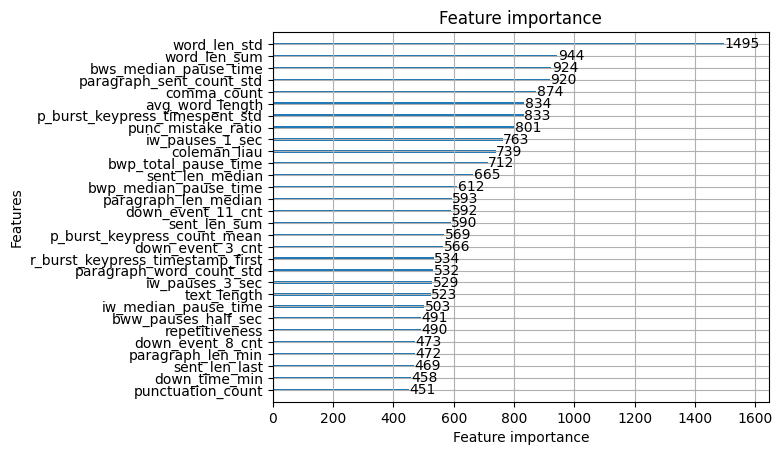

In [12]:
import lightgbm as lightree
import matplotlib.pyplot as plt

lgb=models_and_errors_dict['lgb'][num_folds-1][0]
plt.figure()
lightree.plot_importance(lgb,max_num_features=30)
plt.show()

### Blending

In [13]:
#融合模型的权重
blending_weights = {
    'lgb': 0.4,
    'cat': 0.4,
    'xgb': 0.2,
}
lgb_oof_pred=models_and_errors_dict['lgb'][num_folds-1][4]
cat_oof_pred=models_and_errors_dict['cat'][num_folds-1][4]
xgb_oof_pred=models_and_errors_dict['xgb'][num_folds-1][4]
margin=1000
target=y.values
current_RMSE=RMSE(target,(lgb_oof_pred+cat_oof_pred+xgb_oof_pred)/3)
best_i=0
best_j=0
for i in range(0,margin):
    for j in range(0,margin-i):
        #k=1000-i-j
        blend_oof_pred=(i*lgb_oof_pred+j*cat_oof_pred+(margin-i-j)*xgb_oof_pred)/margin
        if RMSE(target,blend_oof_pred)<current_RMSE:
            current_RMSE=RMSE(target,blend_oof_pred)
            best_i=i
            best_j=j
#找到最好的参数之后
blending_weights['lgb']=best_i/margin
blending_weights['cat']=best_j/margin
blending_weights['xgb']=(margin-best_i-best_j)/margin
print(f"current_RMSE:{current_RMSE},blending_weights:{blending_weights}")
print("blending")
blended_score=np.zeros((len(test_feats)))
for k, v in blending_weights.items():
    blended_score += submission_df['score_' + k] * v
print(f"blended_score:{blended_score}")

current_RMSE:0.5970158808282722,blending_weights:{'lgb': 0.058, 'cat': 0.721, 'xgb': 0.221}
blending
blended_score:0    1.326707
1    1.302349
2    1.311102
Name: score_lgb, dtype: float64


### Submission

In [14]:
submission=pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv")
submission['score']=blended_score
submission.to_csv("submission.csv",index=None)
submission.head()

,id,score
0,0000aaaa,1.326707
1,2222bbbb,1.302349
2,4444cccc,1.311102
